In [1]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

/home/romuald/ENSEIGNEMENT/0-JupyterNotebooks/PytChem


**Start at:** Monday 22 May 2023, 16:06:43  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

$$\varepsilon_{i}(\bar{\nu})=\varepsilon_{i}^{\mathrm{max}}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$
It is demonstrated, in a [Gaussian whitepaper](https://gaussian.com/uvvisplot/), that the previous equation becomes, in the cgs units system:
$$\varepsilon_{i}(\bar{\nu})=\frac{\sqrt{\pi}e^{2}N_{\mathrm{A}}}{1000\ln(10)c^{2}m_{e}}\frac{f_{i}}{\sigma}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$

where:
- $\varepsilon_i$ is the molar absorption coefficient, in units of L∙mol$^{-1}$∙cm$^{-1}$
- $f_i$ is the dimensionless oscillator strength
- $\sigma$, the half-width of the Gaussian band at each $\varepsilon^{\mathrm{max}}$, is in cm$^{-1}$
- $c$ is the speed of light in cm∙s$^{-1}$
- $N_\mathrm{A}$ is the Avogadro number, in mol$^{-1}$
- $m_e$ is the electron mass in g
- $e$ is the elementary charge, in electrostatic unit of charge (esu)

In most cases, there will be more than one electronic excitation in the region of interest. The overall spectrum is obtained from the sum of all the individual bands:

$$\varepsilon(\bar{\nu}) = \sum_{i}^{N}\varepsilon_{i}(\bar{\nu})$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
sigma = 0.3 #eV 0.4 eV is the default value in GaussView
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
sigmanm = eV2nm/sigma
print(f"sigma = {sigma} eV -> sigmanm = {sigmanm:.1f} nm")

def epsiG(lambdaX,lambdai,fi,sigmanm):
    '''
    calculates a Gaussian band shape around a vertical transition
    input:
        - lambdaX = wavelength variable, in nm
        - lambdai = vertical excitation wavelength for ith state, in nm
        - fi = oscillator strength for state i (dimensionless)
        - sigma = half-width of the Gaussian band, in nm
    output :
        molar absorption coefficient, in L mol-1 cm-1
    '''
    import scipy.constants as sc
    import numpy as np
    c = sc.c*1e2 #cm-1
    NA = sc.N_A #mol-1
    me = sc.m_e*1000 #g
    e = sc.e*sc.c*10 #elementary charge in esu 
    pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
    nubarX = 1e7 / lambdaX # nm to cm-1
    nubari = 1e7 / lambdai
    sigmabar = 1e7 / sigmanm
    epsi = pf * (fi / sigmabar) * np.exp(-((nubarX - nubari)/sigmabar)**2)
    return epsi

def Absorbance(eps,opl,cc):
    '''
    Calculates the Absorbance with the Beer-Lambert law
    input:
        - eps = molar absorption coefficient, in L mol-1 cm-1
        - opl = optical path length, in cm
        - cc = concentration of the attenuating species, in mol.L-1
    output :
        Absorbance, A (dimensionless)
    '''
    return eps*opl*cc

def sumStatesWithGf(wavel,wavelTAB,feTAB,sigmanm):
    '''
    '''
    import numpy as np
    sumInt = np.zeros(len(wavel))
    for l in wavel:
        for i in range(len(wavelTAB)):
            sumInt[np.argwhere(l==wavel)[0][0]] += epsiG(l,wavelTAB[i],feTAB[i],sigmanm)
    return sumInt

def FindPeaks(sumInt,height,prom=1):
    '''
    '''
    from scipy.signal import find_peaks
    peaks = find_peaks(sumInt, height = height, threshold = None, distance = 1, prominence=prom)
    PeakIndex = peaks[0][:]
    PeakHeight = peaks[1]['peak_heights'][:]
    return PeakIndex,PeakHeight

def pickPeak(wavel,peaksIndex,peaksH,color,shift=0.01,height=0.04,posAnnotation=0.02):
    '''
    '''
    s=shift
    h=height
    a=posAnnotation
    for i in range(len(peaksIndex)):
        x = wavel[peaksIndex[i]]
        y = peaksH[i]
        plt.vlines(x, y+s, y+s+h, colors=color, linestyles='solid')
        plt.annotate(f"{x:.1f}",xy=(x,y),xytext=(x,y+s+h+a),rotation=90,size=12,ha='center',va='bottom')
    return

def plotTDDFTSpectrum(wavel,sumInt,wavelTAB,feTAB,sigmanm,labelSpectrum,xmin=250,xmax=800,save=False,filename='TDDFT.png',colorS='#0000ff',colorT='#0000cf'):
    '''
    '''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    for i in range(len(wavelTAB)):
        plt.vlines(x = wavelTAB[i], ymin = 0, ymax = epsiG(wavelTAB[i],wavelTAB[i],feTAB[i],sigmanm), colors = colorT)
    plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
    plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
    plt.xticks(fontsize=16,fontweight='bold')
    plt.yticks(fontsize=16,fontweight='bold')
    plt.plot(wavel,sumInt,linewidth=3,linestyle='-',color=colorS,label=labelSpectrum)
    plt.xlim(xmin,xmax)
    plt.legend(fontsize=14)
    
    peaks, peaksH = FindPeaks(sumInt,10)
    pickPeak(wavel,peaks,peaksH,colorS,500,500,200)
    # s=500
    # h=500
    # a=200
    # for i in range(len(peaks)):
    #     x = wavel[peaks[i]]
    #     y = peaksH[i]
    #     plt.vlines(x, y+s, y+s+h, colors=colorS, linestyles='solid')
    #     plt.annotate(f"{x:.1f}",xy=(x,y),xytext=(x,y+s+h+a),rotation=90,size=12,ha='center',va='bottom')
    
    import matplotlib.ticker as ticker
    ax = plt.gca() # this is a way to deefined advanced plot options
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
    if save:
        plt.savefig(filename,dpi=300,transparent=True)
    plt.show()

sigma = 0.3 eV -> sigmanm = 4132.8 nm


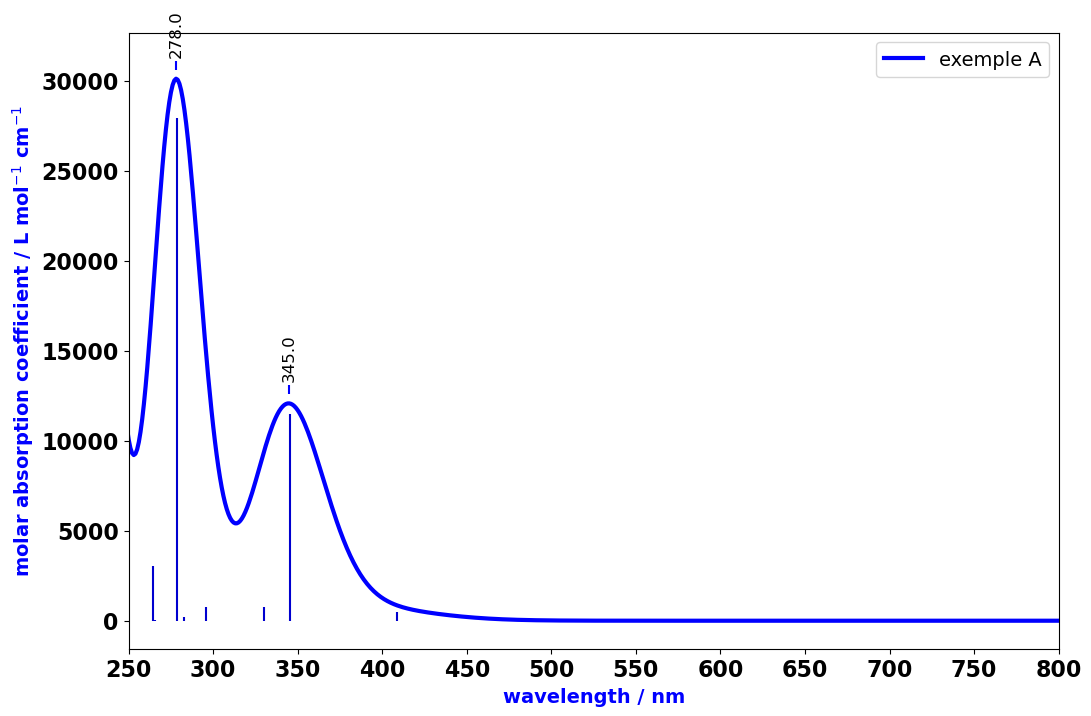

In [7]:
istate,state,wavel,fe,SSq = np.genfromtxt("./EasterEgg/testA.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
wvl = np.arange(200,801,1)
sumInt = sumStatesWithGf(wvl,wavel,fe,sigmanm)
plotTDDFTSpectrum(wvl,sumInt,wavel,fe,sigmanm,"exemple A",250,800,save=False)

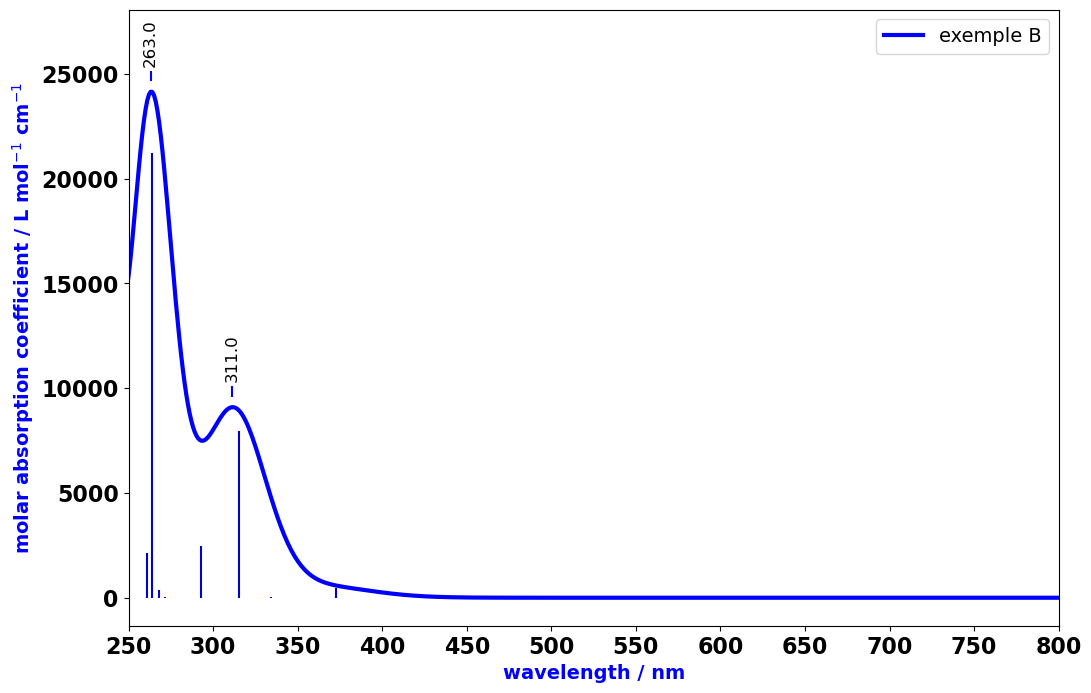

In [6]:
istate,state,wavel,fe,SSq = np.genfromtxt("./EasterEgg/testB.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
wvl = np.arange(200,801,1)
sumInt = sumStatesWithGf(wvl,wavel,fe,sigmanm)
plotTDDFTSpectrum(wvl,sumInt,wavel,fe,sigmanm,"exemple B",250,800,save=False)